### 📦 Import libraries

In [17]:
# Built-in libraries
import os
from collections import defaultdict

# Third-party libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D,
    LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)


### 📂 Load and parse image dataset

In [18]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Applications/Tien/deepfake-models/CelebV2


In [19]:
# Đường dẫn dataset và nhãn
base_path = '/Applications/Tien/deepfake/Dataset/celeb_df_crop'
categories = ['fake', 'real']

data = []

# Duyệt qua từng ảnh trong thư mục fake/real
for label in categories:
    folder_path = os.path.join(base_path, label)
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jpg'):
            continue
        try:
            id_part, frame_part = filename.split('_frame_')
            sample_id = int(id_part.split('_')[0])
            frame_idx = int(frame_part.split('.')[0])
            data.append({
                'filename': filename,
                'path': os.path.join(folder_path, filename),
                'id': sample_id,
                'frame': frame_idx,
                'label': label
            })
        except ValueError:
            # Bỏ qua ảnh sai định dạng
            continue

# Chuyển về DataFrame
df = pd.DataFrame(data)


In [20]:
df

,filename,path,id,frame,label
0,222_id32_0007_frame_0028.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,222,28,fake
1,522_id7_0003_frame_0027.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,522,27,fake
2,501_id60_0007_frame_0022.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,501,22,fake
3,487_id59_0008_frame_0023.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,487,23,fake
4,239_id34_0004_frame_0007.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,239,7,fake
...,...,...,...,...,...
32367,082_id1_0001_frame_0027.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,82,27,real
32368,186_id2_0001_frame_0007.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,186,7,real
32369,200_id30_0005_frame_0014.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,200,14,real
32370,460_id56_0007_frame_0012.jpg,/Applications/Tien/deepfake/Dataset/celeb_df_c...,460,12,real


### 🔁 Encode label

In [21]:
# Chuyển nhãn về số: fake=0, real=1
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})


### 🎞️ Group frames by video

In [22]:
# Tạo khóa duy nhất cho mỗi video dựa trên id và nhãn
df['video_key'] = df['id'].astype(str) + "_" + df['label']

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


### 🏷️ Check label dictionary

In [23]:
labels  # Kiểm tra dict chứa nhãn video

{'222_fake': 0,
 '522_fake': 0,
 '501_fake': 0,
 '487_fake': 0,
 '239_fake': 0,
 '433_fake': 0,
 '35_fake': 0,
 '133_fake': 0,
 '297_fake': 0,
 '77_fake': 0,
 '363_fake': 0,
 '117_fake': 0,
 '234_fake': 0,
 '5_fake': 0,
 '474_fake': 0,
 '89_fake': 0,
 '282_fake': 0,
 '27_fake': 0,
 '372_fake': 0,
 '402_fake': 0,
 '208_fake': 0,
 '482_fake': 0,
 '115_fake': 0,
 '445_fake': 0,
 '458_fake': 0,
 '70_fake': 0,
 '200_fake': 0,
 '82_fake': 0,
 '186_fake': 0,
 '112_fake': 0,
 '354_fake': 0,
 '6_fake': 0,
 '193_fake': 0,
 '448_fake': 0,
 '538_fake': 0,
 '167_fake': 0,
 '10_fake': 0,
 '38_fake': 0,
 '211_fake': 0,
 '460_fake': 0,
 '176_fake': 0,
 '511_fake': 0,
 '57_fake': 0,
 '524_fake': 0,
 '396_fake': 0,
 '0_fake': 0,
 '320_fake': 0,
 '491_fake': 0,
 '244_fake': 0,
 '95_fake': 0,
 '308_fake': 0,
 '481_fake': 0,
 '300_fake': 0,
 '443_fake': 0,
 '154_fake': 0,
 '67_fake': 0,
 '252_fake': 0,
 '492_fake': 0,
 '385_fake': 0,
 '3_fake': 0,
 '382_fake': 0,
 '311_fake': 0,
 '237_fake': 0,
 '272_fake'

In [24]:
!pip install opencv-python


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [30]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Data generator
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    # ========== THÊM PHẦN NÀY ========== ⭐⭐⭐
    def on_epoch_end(self):
        """Called at the end of every epoch"""
        pass
    # ====================================

    # Tiên thêm dô
    # Trích xuất FFT magnitude từ ảnh
    def extract_fft(self, img):
        # Chuyển sang grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # FFT 2D
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude = np.abs(fft_shift)
        
        # Log transform để scale tốt hơn
        magnitude = np.log(1 + magnitude)
        
        # Normalize về [0, 1]
        magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
        
        # Resize về img_size
        magnitude = cv2.resize(magnitude, self.img_size)
        
        # Thêm channel dimension
        magnitude = np.expand_dims(magnitude, axis=-1)
        
        return magnitude.astype('float32')

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        # chỉnh đây nữa nè
        batch_X_spatial, batch_X_freq, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            # đây nữa
            imgs_spatial = []
            imgs_freq = []
            
            for path in frames:
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                
                # img = self.datagen.random_transform(img) if self.augment else img
                # img = img.astype('float32') / 255.0
                # imgs.append(img)
                
                # Spatial branch (RGB)
                img_spatial = self.datagen.random_transform(img) if self.augment else img
                img_spatial = img_spatial.astype('float32') / 255.0
                imgs_spatial.append(img_spatial)
                
                # Frequency branch (FFT magnitude)
                img_freq = self.extract_fft(img)
                imgs_freq.append(img_freq)

            # Padding nếu thiếu frames
            while len(imgs_spatial) < self.sequence_len:
                # imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                imgs_spatial.append(np.zeros((*self.img_size, 3), dtype='float32'))
                imgs_freq.append(np.zeros((*self.img_size, 1), dtype='float32'))
            # batch_X.append(imgs)
            # batch_y.append(self.labels[key])
            batch_X_spatial.append(imgs_spatial)
            batch_X_freq.append(imgs_freq)
            batch_y.append(self.labels[key])

        # return np.array(batch_X), np.array(batch_y
        return (np.array(batch_X_spatial), np.array(batch_X_freq)), np.array(batch_y)


# Build model cải tiến
def build_model(sequence_len, img_size):
    # ============== INPUT ==============
    input_spatial = Input(shape=(sequence_len, *img_size, 3), name='spatial_input')
    input_freq = Input(shape=(sequence_len, *img_size, 1), name='freq_input')
    
    # ============== SPATIAL BRANCH (MobileNetV2) ==============
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = False
    
    spatial_out = GlobalAveragePooling2D()(base_cnn.output)
    spatial_model = Model(inputs=base_cnn.input, outputs=spatial_out)
    spatial_features = TimeDistributed(spatial_model, name='spatial_features')(input_spatial)
    
    # ============== FREQUENCY BRANCH (Custom CNN) ==============
    freq_cnn = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D()
    ], name='freq_cnn')
    
    freq_features = TimeDistributed(freq_cnn, name='freq_features')(input_freq)
    
    # ============== MERGE ==============
    merged = Concatenate(name='merge')([spatial_features, freq_features])
    
    # ============== TEMPORAL (LSTM) ==============
    x = LSTM(64, return_sequences=False, name='lstm')(merged)
    x = Dropout(0.5)(x)
    
    # ============== OUTPUT ==============
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_spatial, input_freq], outputs=output)
    return model
    
# Training K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

     # ========== QUAN TRỌNG: PHẢI CÓ ĐẦY ĐỦ 4 DÒNG NÀY ========== ⭐⭐⭐
    train_dataset = tf.data.Dataset.from_generator(
        lambda: train_gen,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, sequence_len, *img_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, sequence_len, *img_size, 1), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).repeat()  # ⭐ DÒNG 1: BẮT BUỘC

    val_dataset = tf.data.Dataset.from_generator(
        lambda: val_gen,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, sequence_len, *img_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, sequence_len, *img_size, 1), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).repeat()  # ⭐ DÒNG 2: BẮT BUỘC

    steps_per_epoch = len(train_gen)       # ⭐ DÒNG 3: BẮT BUỘC
    validation_steps = len(val_gen)        # ⭐ DÒNG 4: BẮT BUỘC

    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,      # ⭐ BẮT BUỘC
        validation_steps=validation_steps,    # ⭐ BẮT BUỘC
        callbacks=[checkpoint, earlystop, reduce_lr], 
        verbose=1
    )
    # ==============================================================

    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_pred),      # ← y_pred
        'precision': precision_score(y_true, y_pred),    # ← y_pred
        'recall': recall_score(y_true, y_pred),          # ← y_pred
        'f1': f1_score(y_true, y_pred),                  # ← y_pred
        'auc': roc_auc_score(y_true, y_pred_prob)        # AUC vẫn dùng prob
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5240 - loss: 0.7109
Epoch 1: val_accuracy improved from None to 0.49425, saving model to best_model_fold1.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 283s 5s/step - accuracy: 0.5333 - loss: 0.7012 - val_accuracy: 0.4943 - val_loss: 0.7261 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5514 - loss: 0.6903
Epoch 2: val_accuracy improved from 0.49425 to 0.57471, saving model to best_model_fold1.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.5628 - loss: 0.6864 - val_accuracy: 0.5747 - val_loss: 0.6909 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5826 - loss: 0.6596
Epoch 3: val_accuracy did not improve from 0.57471
49/49 ━━━━━━━━━━━━━━━━━━━━ 293s 6s/step - accuracy: 0.6090 - loss: 0.6574 - val_accuracy: 0.5747 - val_loss: 0.6837 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6273 - loss: 0.6442
Epoch 4: val_accuracy improved from 0.57471 to 0.63218, saving model to best_model_fold1.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.6026 - loss: 0.6594 - val_accuracy: 0.6322 - val_loss: 0.6743 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6407 - loss: 0.6389
Epoch 5: val_accuracy improved from 0.63218 to 0.65517, saving model to best_model_fold1.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - accuracy: 0.6372 - loss: 0.6419 - val_accuracy: 0.6552 - val_loss: 0.6688 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6372 - loss: 0.6262
Epoch 6: val_accuracy did not improve from 0.65517
49/49 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.6359 - loss: 0.6283 - val_accuracy: 0.6552 - val_loss: 0.6649 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6850 - loss: 0.6098
Epoch 7: val_accuracy improved from 0.65517 to 0.67816, saving model to best_model_fold1.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.6949 - loss: 0.6108 - val_accuracy: 0.6782 - val_loss: 0.6552 - learning_rate: 1.0000e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6112 - loss: 0.6214
Epoch 8: val_accuracy improved from 0.67816 to 0.68966, saving model to best_model_fold1.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 281s 6s/step - accuracy: 0.6397 - loss: 0.6102 - val_accuracy: 0.6897 - val_loss: 0.6518 - learning_rate: 1.0000e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6778 - loss: 0.5900
Epoch 9: val_accuracy did not improve from 0.68966
49/49 ━━━━━━━━━━━━━━━━━━━━ 281s 6s/step - accuracy: 0.6769 - loss: 0.5925 - val_accuracy: 0.6552 - val_loss: 0.6524 - learning_rate: 1.0000e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7116 - loss: 0.6001
Epoch 10: val_accuracy did not improve from 0.68966
49/49 ━━━━━━━━━━━━━━━━━━━━ 281s 6s/step - accuracy: 0.7038 - loss: 0.5984 - val_accuracy: 0.6552 - val_loss: 0.6441 - learning_rate: 1.0000e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7063 - loss: 0.5683
Epoch 11: val_accuracy did not improve from 0.68966
49/49 ━━━━━━━━━━━━━━━━━━━━ 276s 6s/step - accuracy: 0.7051 - loss: 0.5738 - val_accuracy: 0.6437 - val_loss: 0.6378 - learning_rate: 1.0000e-04
Epoch 12/50
49/49 

/Users/tranthimitien/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step

===== Fold 2 =====
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5877 - loss: 0.6825
Epoch 1: val_accuracy improved from None to 0.58621, saving model to best_model_fold2.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.5744 - loss: 0.6827 - val_accuracy: 0.5862 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5859 - loss: 0.6747
Epoch 2: val_accuracy improved from 0.58621 to 0.62069, saving model to best_model_fold2.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 291s 6s/step - accuracy: 0.5731 - loss: 0.6761 - val_accuracy: 0.6207 - val_loss: 0.6553 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5335 - loss: 0.6797
Epoch 3: val_accuracy improved from 0.62069 to 0.65517, saving model to best_model_fold2.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 286s 6s/step - accuracy: 0.5603 - loss: 0.6770 - val_accuracy: 0.6552 - val_loss: 0.6428 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6086 - loss: 0.6657
Epoch 4: val_accuracy did not improve from 0.65517
49/49 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.6026 - loss: 0.6647 - val_accuracy: 0.6552 - val_loss: 0.6380 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6014 - loss: 0.6534
Epoch 5: val_accuracy did not improve from 0.65517
49/49 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.6128 - loss: 0.6490 - val_accuracy: 0.6437 - val_loss: 0.6276 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6088 - loss: 0.6426
Epoch 6: val_accuracy did not improve from 0.65517
49/49 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - accuracy: 0.6141 - loss: 0.6427 - val_accuracy: 0.6437 - val_loss: 0.6210 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━

/Users/tranthimitien/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step

===== Fold 3 =====
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5232 - loss: 0.7245
Epoch 1: val_accuracy improved from None to 0.52874, saving model to best_model_fold3.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 295s 6s/step - accuracy: 0.5179 - loss: 0.7133 - val_accuracy: 0.5287 - val_loss: 0.7255 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5946 - loss: 0.6773
Epoch 2: val_accuracy improved from 0.52874 to 0.60920, saving model to best_model_fold3.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - accuracy: 0.5718 - loss: 0.6777 - val_accuracy: 0.6092 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6127 - loss: 0.6484
Epoch 3: val_accuracy did not improve from 0.60920
49/49 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.6064 - loss: 0.6549 - val_accuracy: 0.5747 - val_loss: 0.6718 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6340 - loss: 0.6418
Epoch 4: val_accuracy did not improve from 0.60920
49/49 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accuracy: 0.6385 - loss: 0.6388 - val_accuracy: 0.5632 - val_loss: 0.6604 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6576 - loss: 0.6188
Epoch 5: val_accuracy did not improve from 0.60920
49/49 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.6603 - loss: 0.6153 - val_accuracy: 0.5632 - val_loss: 0.6551 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━

/Users/tranthimitien/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step

===== Fold 4 =====
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5066 - loss: 0.7354
Epoch 1: val_accuracy improved from None to 0.51724, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 275s 5s/step - accuracy: 0.5231 - loss: 0.7165 - val_accuracy: 0.5172 - val_loss: 0.6905 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5664 - loss: 0.6898
Epoch 2: val_accuracy improved from 0.51724 to 0.60920, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.5744 - loss: 0.6848 - val_accuracy: 0.6092 - val_loss: 0.6798 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5994 - loss: 0.6733
Epoch 3: val_accuracy improved from 0.60920 to 0.63218, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.5974 - loss: 0.6692 - val_accuracy: 0.6322 - val_loss: 0.6645 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6249 - loss: 0.6486
Epoch 4: val_accuracy improved from 0.63218 to 0.64368, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.6179 - loss: 0.6509 - val_accuracy: 0.6437 - val_loss: 0.6558 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6392 - loss: 0.6295
Epoch 5: val_accuracy improved from 0.64368 to 0.65517, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.6474 - loss: 0.6270 - val_accuracy: 0.6552 - val_loss: 0.6464 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6385 - loss: 0.6338
Epoch 6: val_accuracy did not improve from 0.65517
49/49 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.6410 - loss: 0.6293 - val_accuracy: 0.6552 - val_loss: 0.6384 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6680 - loss: 0.6128
Epoch 7: val_accuracy improved from 0.65517 to 0.66667, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.6410 - loss: 0.6174 - val_accuracy: 0.6667 - val_loss: 0.6323 - learning_rate: 1.0000e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6504 - loss: 0.6252
Epoch 8: val_accuracy did not improve from 0.66667
49/49 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accuracy: 0.6628 - loss: 0.6158 - val_accuracy: 0.6552 - val_loss: 0.6273 - learning_rate: 1.0000e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6293 - loss: 0.6136
Epoch 9: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold4.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.6590 - loss: 0.6051 - val_accuracy: 0.6782 - val_loss: 0.6201 - learning_rate: 1.0000e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6718 - loss: 0.6103
Epoch 10: val_accuracy did not improve from 0.67816
49/49 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.6679 - loss: 0.6056 - val_accuracy: 0.6437 - val_loss: 0.6206 - learning_rate: 1.0000e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6945 - loss: 0.5886
Epoch 11: val_accuracy did not improve from 0.67816
49/49 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.7077 - loss: 0.5748 - val_accuracy: 0.6782 - val_loss: 0.6107 - learning_rate: 1.0000e-04
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6990 - loss: 0.5722
Epoch 12: val_accuracy did not improve from 0.67816
49/49 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.6987 - loss: 0.5761 - val_accuracy: 0.6667 - val_loss: 0.6189 - learning_rate: 1.0000e-04
Epoch 13/50
49/4

/Users/tranthimitien/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step

===== Fold 5 =====
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5188 - loss: 0.7215
Epoch 1: val_accuracy improved from None to 0.54023, saving model to best_model_fold5.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 301s 6s/step - accuracy: 0.5327 - loss: 0.7019 - val_accuracy: 0.5402 - val_loss: 0.6973 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4924 - loss: 0.7080
Epoch 2: val_accuracy did not improve from 0.54023
49/49 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.5301 - loss: 0.6949 - val_accuracy: 0.5402 - val_loss: 0.7007 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5592 - loss: 0.6786
Epoch 3: val_accuracy did not improve from 0.54023
49/49 ━━━━━━━━━━━━━━━━━━━━ 275s 6s/step - accuracy: 0.5659 - loss: 0.6842 - val_accuracy: 0.5057 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5915 - loss: 0.6661
Epoch 4: val_accuracy did not improve from 0.54023
49/49 ━━━━━━━━━━━━━━━━━━━━ 274s 6s/step - accuracy: 0.6005 - loss: 0.6618 - val_accuracy: 0.5172 - val_loss: 0.6965 - learning_rate: 5.0000e-05
Epoch 5/50
49/49 ━━━━━

/Users/tranthimitien/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step

📊 Tổng kết kết quả các fold:
Fold 1: Accuracy=0.6959, F1=0.6916, AUC=0.7703
Fold 2: Accuracy=0.6267, F1=0.5803, AUC=0.6539
Fold 3: Accuracy=0.6037, F1=0.6195, AUC=0.7006
Fold 4: Accuracy=0.6544, F1=0.6154, AUC=0.7307
Fold 5: Accuracy=0.5926, F1=0.4824, AUC=0.6427


In [31]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.634648
precision    0.662838
recall       0.555199
f1           0.597821
auc          0.699650
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.695853,0.698113,0.685185,0.691589,0.770302
1,2,0.626728,0.658824,0.518519,0.580311,0.653925
2,3,0.603687,0.598291,0.642202,0.619469,0.700561
3,4,0.654378,0.697674,0.550459,0.615385,0.730717
4,5,0.592593,0.661290,0.379630,0.482353,0.642747


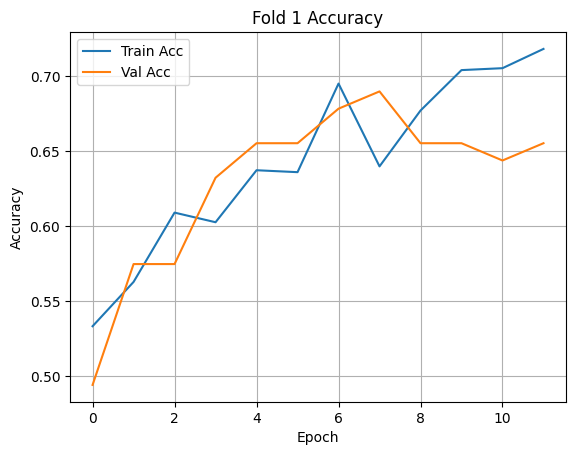

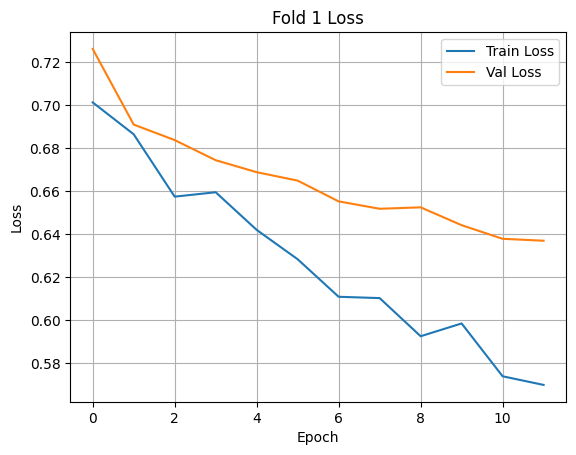

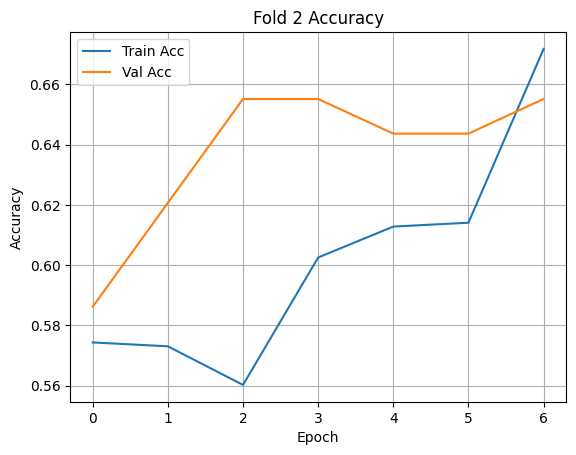

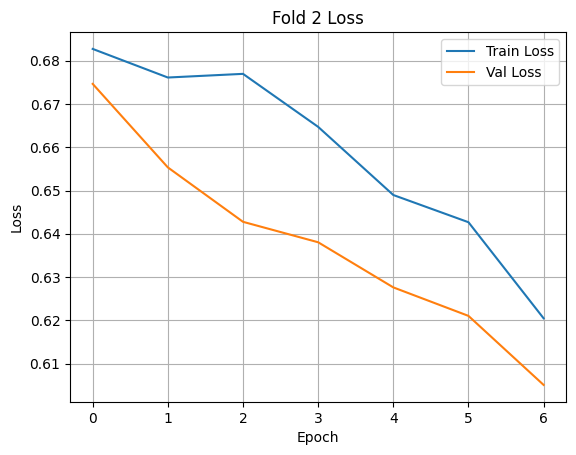

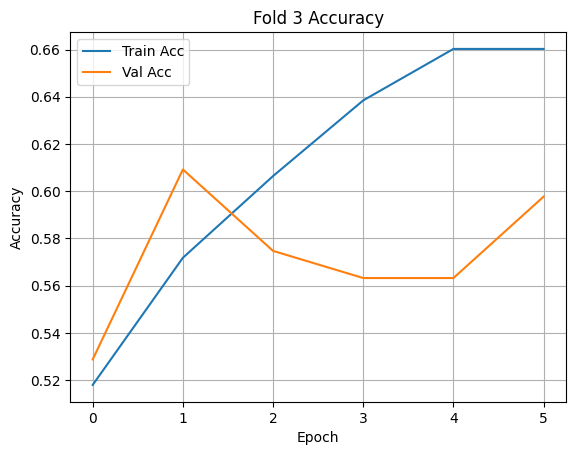

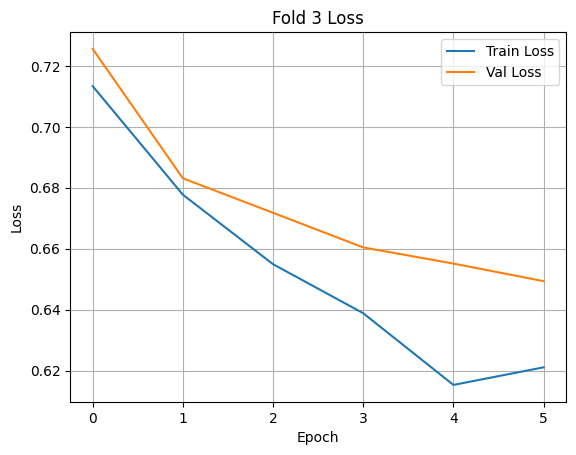

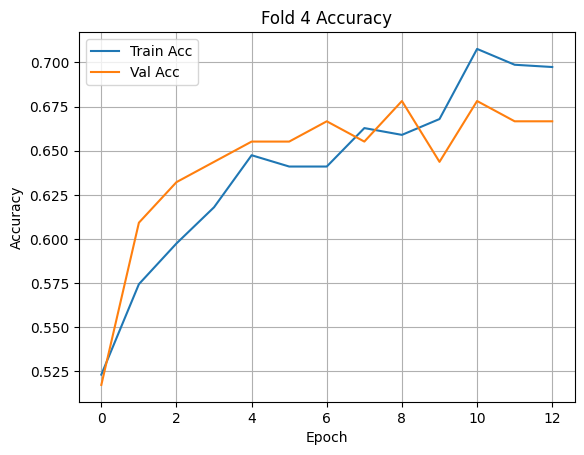

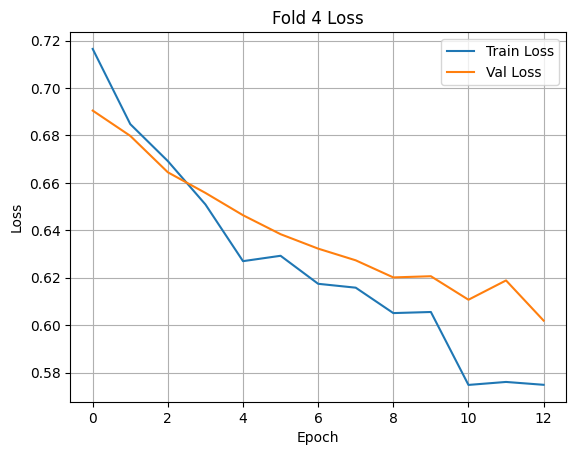

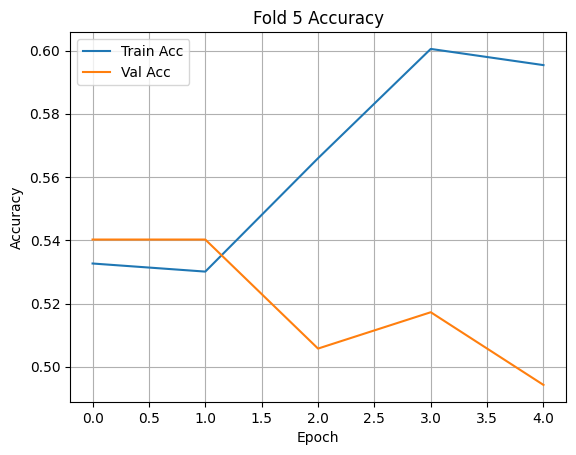

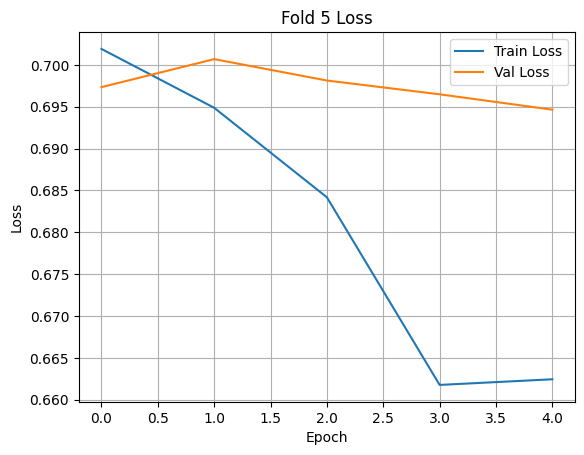

In [32]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [33]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_faceplus_final.h5")


In [34]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.634648
precision    0.662838
recall       0.555199
f1           0.597821
auc          0.699650
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.6346
📈 Range Accuracy: 0.1033
📉 Accuracy CV% (std/mean): 6.56%


,fold,accuracy,precision,recall,f1,auc
0,1,0.695853,0.698113,0.685185,0.691589,0.770302
1,2,0.626728,0.658824,0.518519,0.580311,0.653925
2,3,0.603687,0.598291,0.642202,0.619469,0.700561
3,4,0.654378,0.697674,0.550459,0.615385,0.730717
4,5,0.592593,0.661290,0.379630,0.482353,0.642747
